In this notebook, I will try to 
- Download the mnist dataset using pythons url retrieve.
- Create dataset and dataloader objects.
- Create a linear model model and train it.
- Visualize GPU usage during training.
- Visualize model parameter properties during training.

# Iteration 1: Download and train

For this iteration, I will try to create a working model as fast and minimal as I can. The only concern is to create a working model and see the loss and accuracy of my model.

## Download MNIST

In [4]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [5]:
from pathlib import Path

data_path = Path("../data")
data_path.mkdir(exist_ok=True)

mnist_path = data_path / 'mnist.pkl.gz'
data_path.resolve(), mnist_path.resolve()

(PosixPath('/home/ec2-user/app/data'),
 PosixPath('/home/ec2-user/app/data/mnist.pkl.gz'))

In [6]:
from urllib.request import urlretrieve

if not mnist_path.exists(): urlretrieve(MNIST_URL, mnist_path)
!ls ../data

mnist.pkl  mnist.pkl.gz


## Decompress & load

In [7]:
import gzip
import shutil

mnist_pkl_path = data_path / 'mnist.pkl'

if not mnist_pkl_path.exists():
    with gzip.open(mnist_path, 'rb') as f_in:
        with open(mnist_pkl_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

!ls ../data

mnist.pkl  mnist.pkl.gz


In [8]:
import pickle

with open(mnist_pkl_path, 'rb') as file:
    mnist_data = pickle.load(file, encoding='latin1')

((x_train_np, y_train_np), (x_valid_np, y_valid_np), _) = mnist_data

In [9]:
import torch

torch.set_printoptions(linewidth=140)
torch.manual_seed(42)

In [10]:
x_train, y_train, x_valid, y_valid = torch.tensor(x_train_np), torch.tensor(y_train_np), torch.tensor(x_valid_np), torch.tensor(y_valid_np)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

## Visualize an image

(<matplotlib.image.AxesImage at 0x7f0e1d130810>, tensor(5))

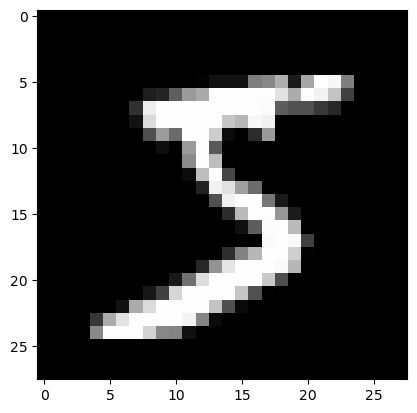

In [11]:
from matplotlib import pyplot as plt

plt.imshow(x_train[0].reshape(-1, 28), cmap='grey'), y_train[0]

## Simple linear model

In [103]:
# The model will have 28*28 input layer, no hidden layer, and 10 output layers.
# The ten outputs each will have 784 weights and one bias. So the model has 7840 + 10 parameters.

class Linear():
    def __init__(self):
        n_out = 10
        n_in = x_train.shape[1]
        self.weights = torch.rand((n_in, n_out))
        self.biases = torch.rand(n_out)

    def forward(self, xb):
        return torch.einsum('ij,jk->ik', xb, self.weights) + self.biases

In [104]:
model = Linear()
preds = model.forward(x_train[:5]); preds

tensor([[57.5381, 59.7699, 53.1264, 51.5986, 55.3418, 50.2172, 58.1080, 52.3050, 54.2571, 55.8246],
        [61.1310, 66.0725, 60.7356, 58.0723, 61.8369, 59.2643, 63.4841, 60.1125, 65.1666, 66.0998],
        [36.7878, 37.3787, 37.7708, 38.4218, 41.6881, 34.1316, 40.6621, 39.0544, 41.8729, 40.5128],
        [33.8475, 36.3857, 32.8703, 36.4713, 35.3677, 35.5467, 36.2017, 32.9389, 33.2640, 40.6796],
        [45.8887, 45.4374, 46.2041, 42.6716, 48.3483, 43.5569, 48.0709, 47.9589, 48.3373, 52.9960]])

## Softmax

In [105]:
preds = preds.exp() / preds.exp().sum(1)[:, None]; preds

tensor([[8.0419e-02, 7.4925e-01, 9.7592e-04, 2.1178e-04, 8.9444e-03, 5.3207e-05, 1.4220e-01, 4.2923e-04, 3.0232e-03, 1.4495e-02],
        [2.8153e-03, 3.9410e-01, 1.8960e-03, 1.3218e-04, 5.7027e-03, 4.3535e-04, 2.9612e-02, 1.0167e-03, 1.5929e-01, 4.0499e-01],
        [2.4638e-03, 4.4487e-03, 6.5843e-03, 1.2625e-02, 3.3097e-01, 1.7300e-04, 1.1863e-01, 2.3768e-02, 3.9816e-01, 1.0218e-01],
        [1.0242e-03, 1.2962e-02, 3.8544e-04, 1.4120e-02, 4.6832e-03, 5.6013e-03, 1.0784e-02, 4.1279e-04, 5.7140e-04, 9.4946e-01],
        [7.9115e-04, 5.0379e-04, 1.0844e-03, 3.1701e-05, 9.2558e-03, 7.6831e-05, 7.0137e-03, 6.2707e-03, 9.1545e-03, 9.6582e-01]])

In [106]:
classes = torch.arange(0, 10); classes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<BarContainer object of 10 artists>

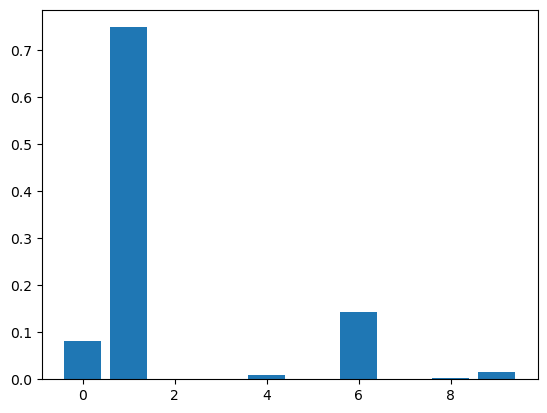

In [107]:
plt.bar(classes, preds[0])

In [108]:
import numpy as np
np.set_printoptions(linewidth=180)

In [109]:
torch.max(preds, axis=1).values[:, None]

tensor([[0.7492],
        [0.4050],
        [0.3982],
        [0.9495],
        [0.9658]])

In [178]:
def softmax(x): 
    x = x - torch.max(x, axis=1).values[:, None]
    return x.exp() / x.exp().sum(1)[:, None]

class Linear():
    def __init__(self, final_act=softmax):
        n_out = 10
        n_in = x_train.shape[1]
        self.weights = torch.rand((n_in, n_out))
        self.biases = torch.rand(n_out)
        self.final_act = final_act

    def forward(self, xb):
        return self.final_act(torch.einsum('ij,jk->ik', xb, self.weights) + self.biases)

    def train(self):
        self.weights.requires_grad_(True)
        self.biases.requires_grad_(True)
    
    def eval(self):
        self.weights.requires_grad_(False)
        self.biases.requires_grad_(False)

In [179]:
model = Linear()
preds = model.forward(x_train[:5]); preds

tensor([[3.4966e-03, 9.3515e-05, 6.9504e-04, 8.5250e-01, 1.4529e-02, 3.3481e-03, 8.3933e-02, 1.1744e-02, 1.5557e-02, 1.4107e-02],
        [1.5890e-03, 3.6799e-06, 8.2940e-05, 8.6565e-04, 2.1798e-05, 2.2139e-04, 9.9333e-01, 6.2456e-04, 1.2658e-04, 3.1330e-03],
        [2.1488e-02, 1.9553e-02, 1.6595e-01, 1.8106e-01, 1.6877e-01, 2.0404e-01, 1.5550e-01, 2.9267e-02, 4.6156e-02, 8.2191e-03],
        [1.2782e-01, 9.8765e-03, 1.9473e-02, 6.1934e-01, 5.4203e-02, 6.0890e-02, 1.8767e-02, 2.3606e-02, 6.1433e-02, 4.6000e-03],
        [1.7558e-01, 2.1133e-02, 8.5846e-03, 6.2476e-01, 2.0836e-02, 1.7236e-03, 1.0277e-01, 4.2586e-02, 5.2362e-04, 1.5069e-03]])

<BarContainer object of 10 artists>

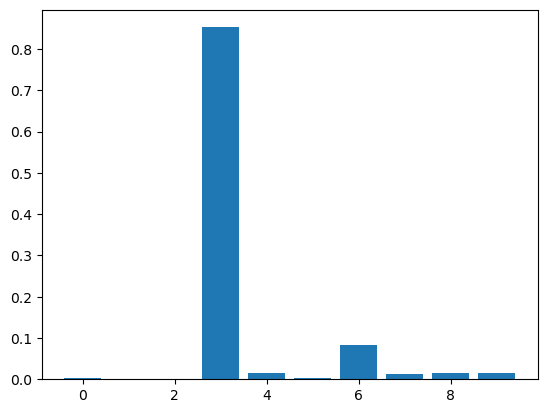

In [180]:
plt.bar(classes, preds[0])

In [181]:
from fastcore.all import *
import torch.nn.functional as F

In [182]:
test_close(F.softmax(preds, dim=1), softmax(preds))

## Loss function

In [183]:
y_train_oh = F.one_hot(y_train, num_classes=len(classes))

# should give me a big loss for 5
(y_train_oh[:5]*preds.log()).sum(1)

tensor([-5.6994, -6.4446, -1.7792, -4.6176, -6.4977])

In [184]:
# should be zero
true_pred = torch.zeros(10); true_pred[5] = 1; true_pred
y_train_oh[0]*true_pred.log()

tensor([nan, nan, nan, nan, nan, 0., nan, nan, nan, nan])

In [185]:
def ce_loss(preds, targets_oh):
    return (-targets_oh*preds.log()).sum(1)

In [186]:
ce_loss(preds, y_train_oh[:5])

tensor([5.6994, 6.4446, 1.7792, 4.6176, 6.4977])

## Training

In [196]:
torch.randn(10, 2).max(0)

torch.return_types.max(
values=tensor([2.7945, 1.6945]),
indices=tensor([5, 2]))

In [214]:
epoch = 50
lr = 0.01
bs = 64

for e in range(epoch):
    epoch_loss = 0
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    print(f'Epoch: {e+1} | Loss: {loss:.2f} | Accuracy: {accuracy:.2f}')


Epoch: 0 | Loss: 0.42 | Accuracy: 0.89
Epoch: 1 | Loss: 0.40 | Accuracy: 0.89
Epoch: 2 | Loss: 0.39 | Accuracy: 0.90
Epoch: 3 | Loss: 0.38 | Accuracy: 0.90
Epoch: 4 | Loss: 0.37 | Accuracy: 0.90
Epoch: 5 | Loss: 0.36 | Accuracy: 0.90
Epoch: 6 | Loss: 0.36 | Accuracy: 0.90
Epoch: 7 | Loss: 0.35 | Accuracy: 0.90
Epoch: 8 | Loss: 0.34 | Accuracy: 0.90
Epoch: 9 | Loss: 0.34 | Accuracy: 0.91
Epoch: 10 | Loss: 0.34 | Accuracy: 0.91
Epoch: 11 | Loss: 0.33 | Accuracy: 0.91
Epoch: 12 | Loss: 0.33 | Accuracy: 0.91
Epoch: 13 | Loss: 0.32 | Accuracy: 0.91
Epoch: 14 | Loss: 0.32 | Accuracy: 0.91
Epoch: 15 | Loss: 0.32 | Accuracy: 0.91
Epoch: 16 | Loss: 0.31 | Accuracy: 0.91
Epoch: 17 | Loss: 0.31 | Accuracy: 0.91
Epoch: 18 | Loss: 0.31 | Accuracy: 0.91
Epoch: 19 | Loss: 0.31 | Accuracy: 0.91
Epoch: 20 | Loss: 0.30 | Accuracy: 0.91
Epoch: 21 | Loss: 0.30 | Accuracy: 0.91
Epoch: 22 | Loss: 0.30 | Accuracy: 0.91
Epoch: 23 | Loss: 0.30 | Accuracy: 0.91
Epoch: 24 | Loss: 0.30 | Accuracy: 0.91
Epoch: 25 